## Using Machine Learning to Forecast Overall Conversion

# Importing libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Loading the dataset

In [29]:
df = pd.read_csv('data.csv')
df=df.rename(columns={'Overall Conv':'overall_conv','Uninstall rate':'uninstall_rate',
                      'Page view conversion':'page_view_conversion','AddtoCart (Prod page)':'add_to_cart'})
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

# cleaning the percentage column; remove percentage symbol

In [30]:
per_col = ['uninstall_rate','page_view_conversion','add_to_cart','overall_conv']
for i in per_col:
    df[i] = df[i].str.replace('%','',regex=True).astype('float')

In [31]:
df_overall=df['overall_conv'].copy()
df_overall=df_overall.to_frame().reset_index()
df_overall = df_overall.set_index('Date')
df_overall.index = pd.to_datetime(df_overall.index)

In [32]:
df_overall.head()

,overall_conv
Date,
2021-09-01,3.43
2021-09-02,3.29
2021-09-03,1.96
2021-09-04,2.54
2021-09-05,2.34


# Exploratory Data Analysis

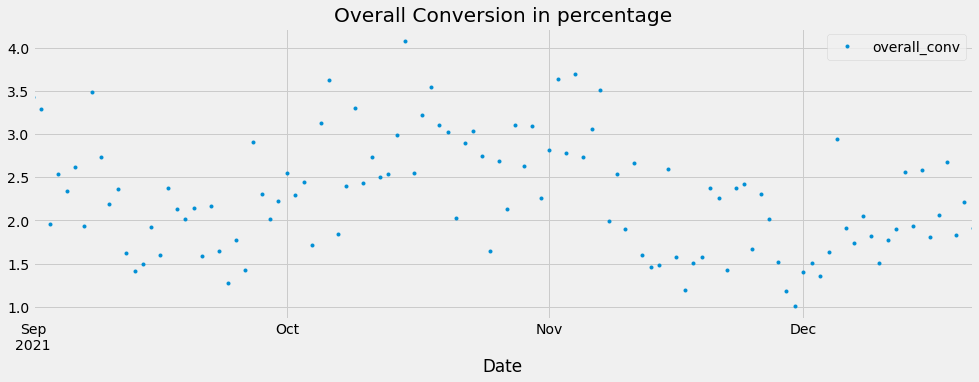

In [33]:
df_overall.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Overall Conversion in percentage')
plt.show()

In [34]:
print(df_overall.min())
print(df_overall.max())

overall_conv    1.01
dtype: float64
overall_conv    4.08
dtype: float64


### Filtering outlier and visualizing dataset

<AxesSubplot:title={'center':'Outliers'}, xlabel='Date'>

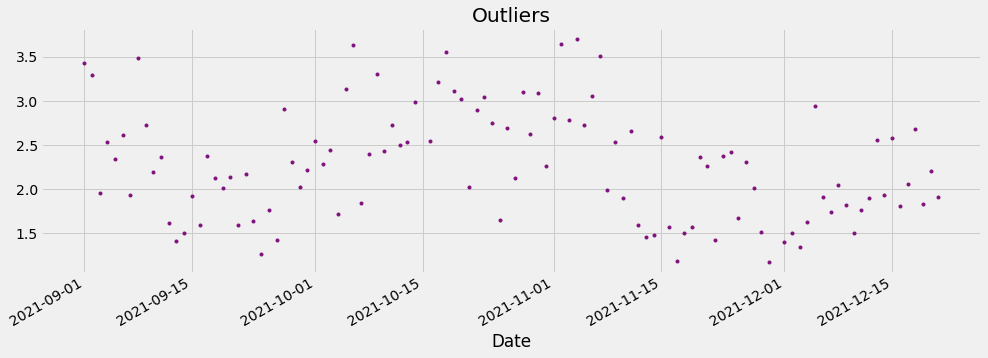

In [37]:
df_overall=df_overall.query('overall_conv < 4.08 & overall_conv > 1.01')
df_overall['overall_conv'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

# Time Series Cross Validation

In [38]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=30, gap=1)
df_overall = df_overall.sort_index()

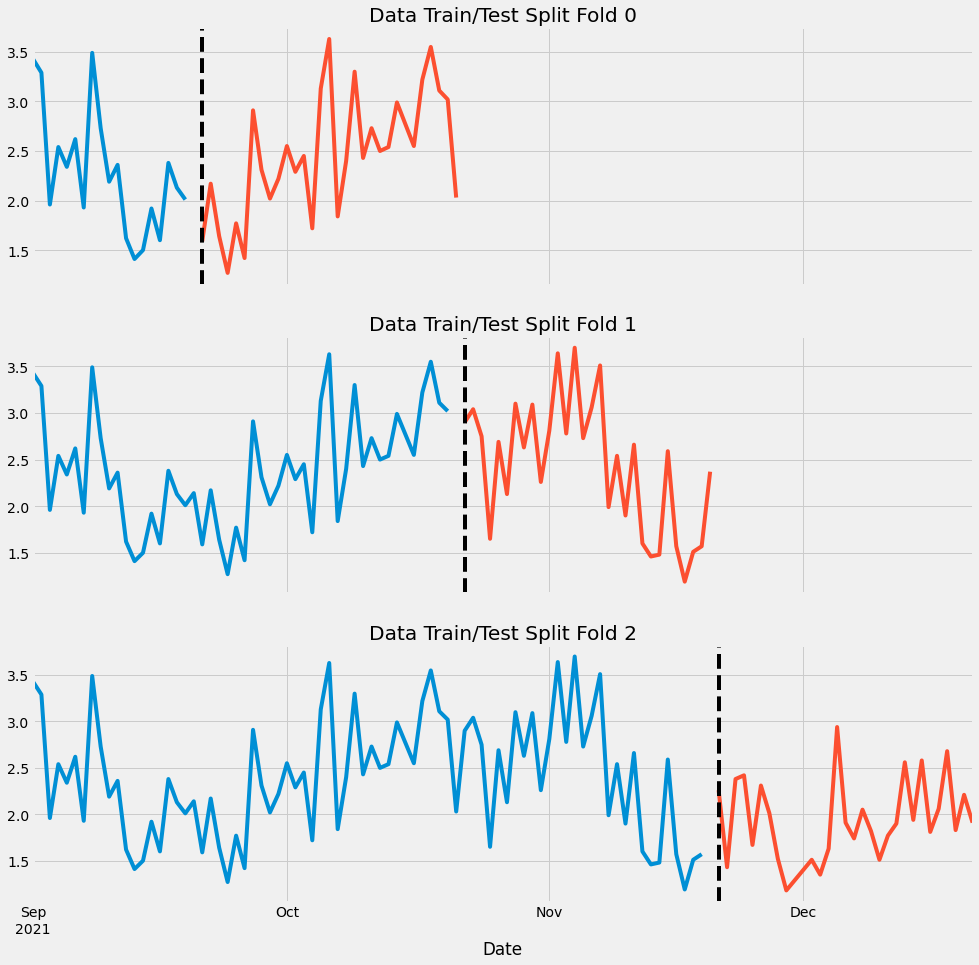

In [39]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_overall):
    train = df_overall.iloc[train_idx]
    test = df_overall.iloc[val_idx]
    train['overall_conv'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['overall_conv'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Forecasting Horizon 
**Creating features with index column.**

In [40]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_overall = create_features(df_overall)

In [41]:
df_overall.index = pd.to_datetime(df_overall.index)

In [42]:
df_overall.head()

,overall_conv,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,
2021-09-01,3.43,0,2,3,9,2021,244,1,35
2021-09-02,3.29,0,3,3,9,2021,245,2,35
2021-09-03,1.96,0,4,3,9,2021,246,3,35
2021-09-04,2.54,0,5,3,9,2021,247,4,35
2021-09-05,2.34,0,6,3,9,2021,248,5,35


## Train Using Cross Validation

In [43]:
tss = TimeSeriesSplit(n_splits=3, test_size=30, gap=1)
df_overall = df_overall.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year']
#                 'lag1','lag2','lag3']
    TARGET = 'overall_conv'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[09:50:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.82896	validation_1-rmse:2.14415
[100]	validation_0-rmse:0.82308	validation_1-rmse:1.42245
[200]	validation_0-rmse:0.40797	validation_1-rmse:1.28291
[300]	validation_0-rmse:0.22702	validation_1-rmse:1.18573
[400]	validation_0-rmse:0.14271	validation_1-rmse:1.13410
[500]	validation_0-rmse:0.10225	validation_1-rmse:1.11178
[600]	validation_0-rmse:0.07801	validation_1-rmse:1.10262
[700]	validation_0-rmse:0.06332	validation_1-rmse:1.09674
[800]	validation_0-rmse:0.05118	validation_1-rmse:1.09104
[900]	validation_0-rmse:0.04250	validation_1-rmse:1.08817
[996]	validation_0-rmse:0.03479	validation_1-rmse:1.08796
[09:50:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-window

In [44]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.7574
Fold scores:[1.0876426947659632, 0.7274576477134975, 0.45704376862639556]


# Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [45]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
#             'lag1','lag2','lag3']
TARGET = 'overall_conv'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[09:51:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.87789
[100]	validation_0-rmse:0.82916
[200]	validation_0-rmse:0.50201
[300]	validation_0-rmse:0.42113
[400]	validation_0-rmse:0.38904
[499]	validation_0-rmse:0.36592


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [46]:
df_overall.index.max()

Timestamp('2021-12-21 00:00:00')

In [47]:
# Create future dataframe
future = pd.date_range('2021-12-22','2022-01-21', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_overall['isFuture'] = False
df_overall_and_future = pd.concat([df_overall, future_df])
df_overall_and_future = create_features(df_overall_and_future)
# df_overall_and_future = add_lags(df_overall_and_future)

In [48]:
future_w_features = df_overall_and_future.query('isFuture').copy()

## Predict overall conversion for next 30 days

In [49]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

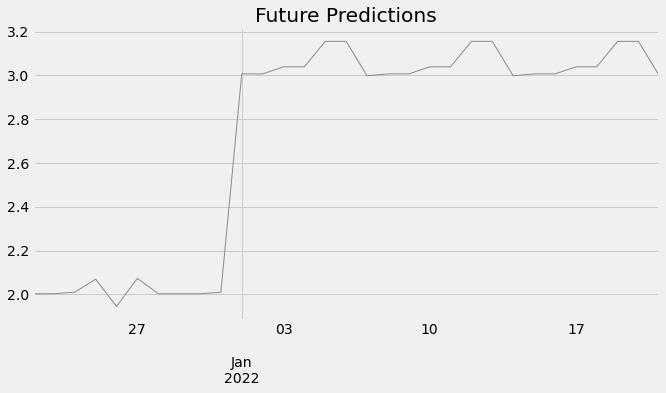

In [50]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Saving Model For later

In [51]:
# Save model
reg.save_model('overall_model.json')

<AxesSubplot:title={'center':'Future Predictions'}>

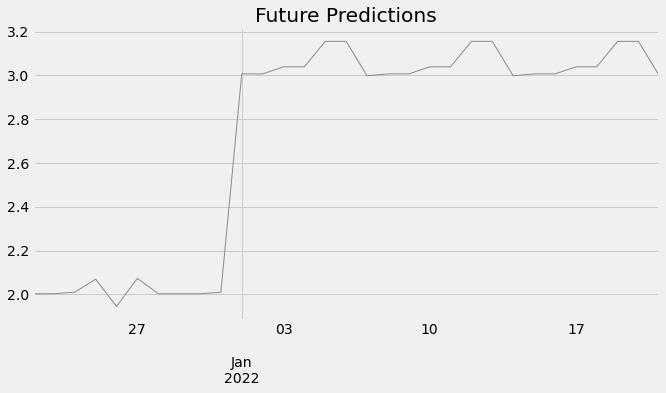

In [52]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('overall_model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

In [53]:
future_w_features['pred'].to_csv('overall_conv_next_30days.csv')